In [1]:
import numpy as np
import pandas as pd

from gtda.time_series import SlidingWindow
from gtda.diagrams import PersistenceLandscape
from gtda.homology import VietorisRipsPersistence

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
# !pip install spectrum 
# from spectrum.periodogram import speriodogram

import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

from pylab import *

from scipy import signal

import statsmodels as sm

import matplotlib.gridspec as gridspec

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Functions to compute the Lp norms

# Find the range of x values from the persistence diagram:
#### THIS FUNCTION ULTIMATELY DID NOT GET USED#####
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
##### AUCORIGINAL AND AUCUPDATED ARE METHODS BY AREA UNDER THE CURVE. THEY DID NOT GET USED. 
##### ONLY THE ELSE STATEMENT GETS USED IN THE COMPUTATION #########

def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p == 'aucoriginal':
        layervalues = landscapevalues[layers]
        for point in zip(tseq,layervalues):
            norms.append(np.trapz(layervalues, tseq))
        return(sum(norms))
    elif p == 'aucUpdated':
        layervalues = landscapevalues[layers]
        return (np.trapz(layervalues))
    else:
        normvalues = []
        for layer in range(layers, 2*layers):
            layervalues = landscapevalues[layer]
            normvalue = np.linalg.norm(layervalues,p)**p
            if normvalue == 0:
                break
            else: 
                normvalues.append(normvalue)
        return (np.sum(normvalues)**(1/p))

In [3]:
# Read AR Synthetic Time Series
y1 = pd.read_csv('AR Time Series.csv')['x']

# Read Sunspot Data
ss = pd.read_csv('Sunspot Data.csv')
ss = ss.iloc[:,0].apply(lambda x : x.split(';')[1])
ss = ss.astype(float)

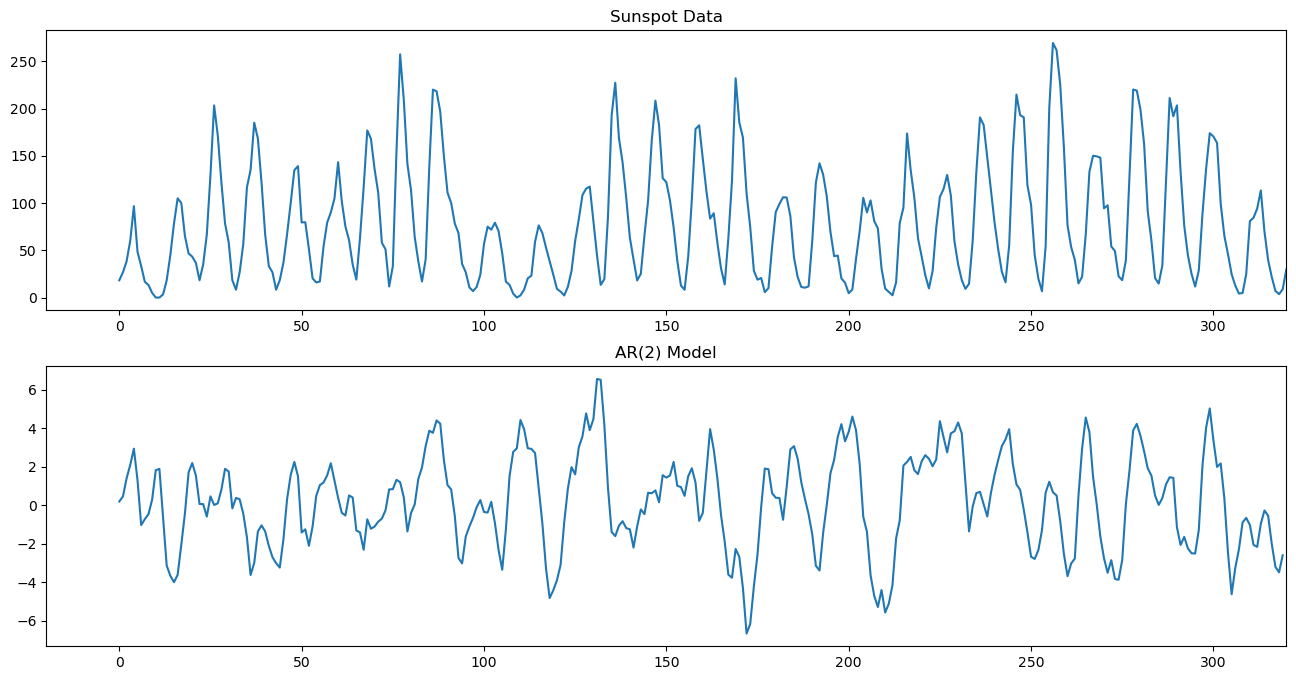

In [4]:
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
labels = 10.85* np.array(ticks)


figure(figsize = (16,8))
plt.subplot(2,1,2)
plt.plot(np.array(y1)[:320]
#          ,label = '[1.381, -.6087]'
        )
plt.xlim([-20, 320])
plt.title('AR(2) Model')
plt.subplot(2,1,1)
plt.plot(list(ss))
plt.title('Sunspot Data')
plt.xlim([-20, 320])

plt.show()

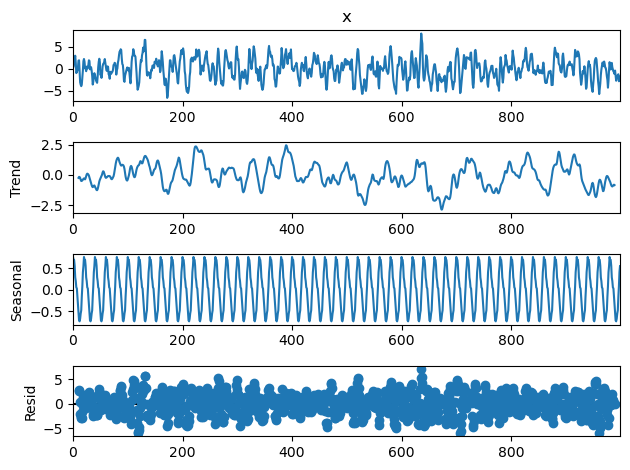

In [5]:
# seasonality of synthetic AR time series
decompose = seasonal_decompose(y1, period = 20)
decompose.plot()
plt.show()

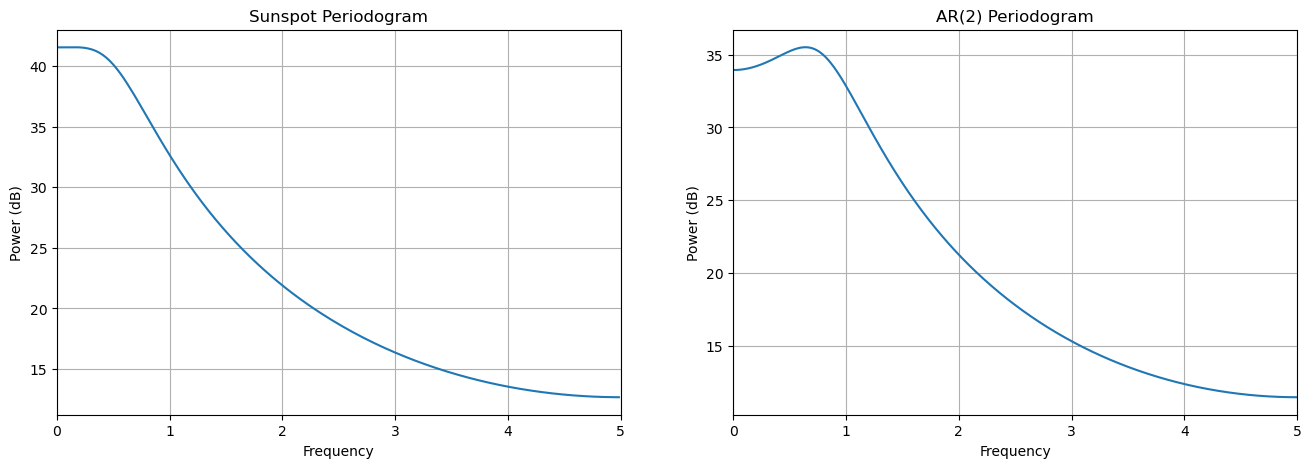

In [6]:
from spectrum import Periodogram, pyule
figure(figsize = (16,5))
plt.subplot(1,2,2)
# p = Periodogram(y1, sampling = 10,scale_by_freq=True)
# p.run()
# p.plot()
p = pyule(y1, 2, sampling=10)
p.plot()
plt.title('AR(2) Periodogram')


plt.subplot(1,2,1)
# p = Periodogram(ss,sampling=10)
# p.run()
# p.plot()
p = pyule(ss, 2, sampling=10, scale_by_freq=False)
plt.title('Sunspot Periodogram')
p.plot()
plt.show()

In [7]:
len(y1)

1000

In [8]:
len(simulated_data)

NameError: name 'simulated_data' is not defined

In [9]:
len(X_sw)

NameError: name 'X_sw' is not defined

In [10]:
simulated_data.tail(50)

NameError: name 'simulated_data' is not defined

In [11]:
X_sw[949]

NameError: name 'X_sw' is not defined

In [12]:
simulated_data = pd.DataFrame({'Simulated Data 1' : y1
             })
simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(1)
simulated_data = simulated_data.dropna()

# Sliding window
window_size = 50
stride = 1
df = simulated_data
X = df
y = df.index
SW = SlidingWindow(size=window_size, stride=stride)
X_sw, yr = SW.fit_transform_resample(X, y)

In [15]:
simulated_data.cov()

,Simulated Data 1,Simulated Data 2
Simulated Data 1,5.80942,4.996770
Simulated Data 2,4.99677,5.806343


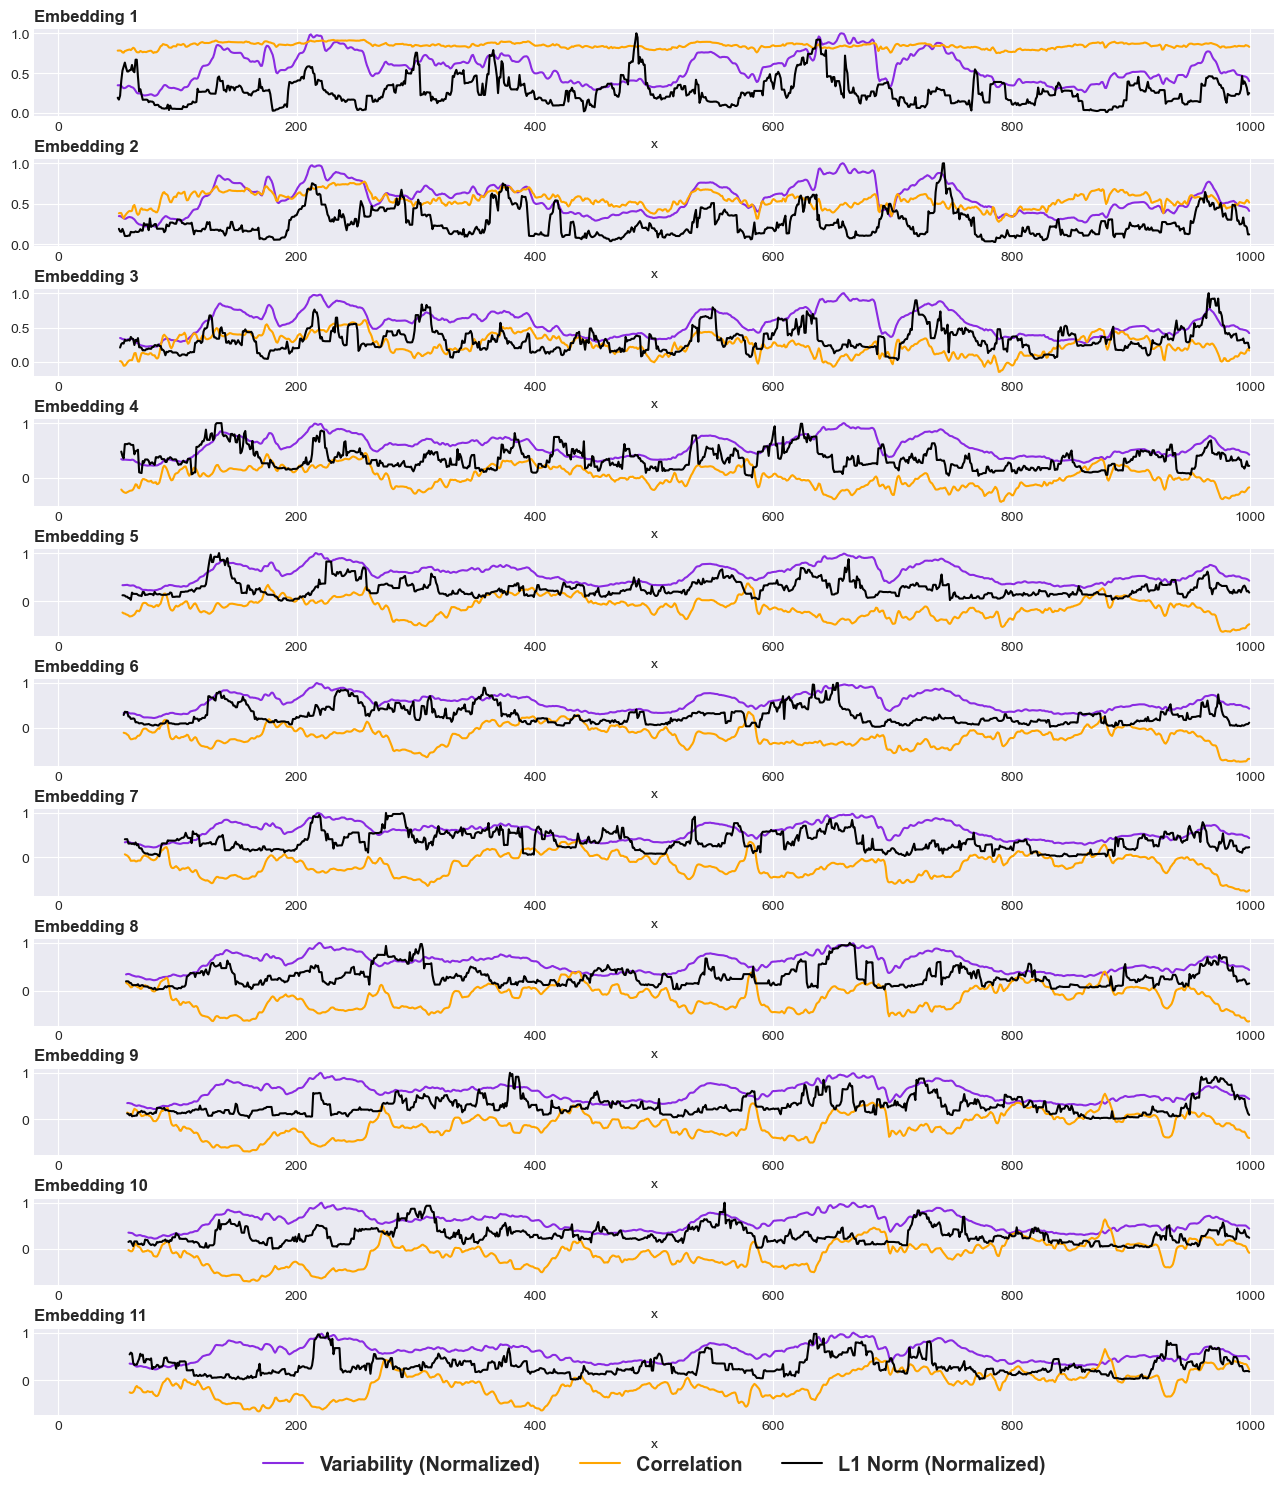

In [8]:
avgl1normsnonoise = []
avgl2normsnonoise = []

# Run periodogram
from spectrum import Periodogram
p = Periodogram(y1
#                 , sampling=len(simulated_data1)
               )
p.run()

plt.figure(figsize = (16,18))
i = 1


# Run TDA on embeddings in 1 period of the AR model
for lag in range(1,12):
    simulated_data = pd.DataFrame({'Simulated Data 1' : y1
                 })
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()

    # Sliding window
    window_size = 50
    stride = 1
    df = simulated_data
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms, variability and correlations for each of the windows in the multivariate sliding window
    variabilitys = np.empty(window_size -1 + lag)
    variabilitys[:] = np.nan
    variabilitys = list(variabilitys)

    correlations = np.empty(window_size -1 + lag)
    correlations[:] = np.nan
    correlations = list(correlations)
    
    Norms = np.empty(window_size-1 + lag)
    Norms[:] = np.nan
    Norms = list(Norms)
    
    l2Norms = np.empty(window_size-1 + lag)
    l2Norms[:] = np.nan
    l2Norms = list(l2Norms)
    
    # compute rips filtration, p diagram, p landscape and norms. Append accordingly.
    layers = 10
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape(layers)
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        Norms.append(Lpnorm(tseq, landscapedata[0], p = 1))    
        l2Norms.append(Lpnorm(tseq, landscapedata[0], p = 2))
    
        pointcloudcovmatrix = np.array(pd.DataFrame(pointcloud).cov())
        variabilitys.append((pointcloudcovmatrix[0][0]  + pointcloudcovmatrix[1][1]) / 2)
    
        pointcloudcorrmatrix = np.array(pd.DataFrame(pointcloud).corr())
        correlations.append(np.round(pointcloudcorrmatrix[0][1], 5))

    # Normalize
    simulateddata1normalized = simulated_data['Simulated Data 1']/simulated_data['Simulated Data 1'].max()
    simulateddata2normalized = simulated_data['Simulated Data 2']/simulated_data['Simulated Data 2'].max()
    avgl1normsnonoise.append(pd.Series(Norms).mean())
    avgl2normsnonoise.append(pd.Series(l2Norms).mean())
    Norms = np.array(Norms) / pd.Series(Norms).max() if pd.Series(Norms).max() != 0 else np.array(Norms)*0
    l2Norms = np.array(l2Norms) / pd.Series(l2Norms).max() if pd.Series(l2Norms).max() != 0 else np.array(l2Norms)*0
    variabilitys = np.array(variabilitys) / pd.Series(variabilitys).max() if pd.Series(variabilitys).max() != 0 else np.array(variabilitys)*0

    # Plot
    plt.style.use('seaborn-darkgrid')
    plt.subplot(11,1,i)
    plt.subplots_adjust(hspace=.5)
    plt.plot(variabilitys, color = 'blueviolet', label = 'Variability (Normalized)')
    corrlabel = 'Correlation'
    plt.plot(correlations, color = 'orange', label = corrlabel)
    plt.plot(Norms, color = 'black', label = 'L1 Norm (Normalized)')
    plt.title(f'Embedding {lag}', fontweight = 'bold', loc='left')
    plt.xlabel('x')
    plt.xlim([-20,1020])
    i +=1
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=3, prop={'size': 'x-large', 'weight': 'bold'})
plt.show()
    
    
    
    

### Anomaly Analaysis

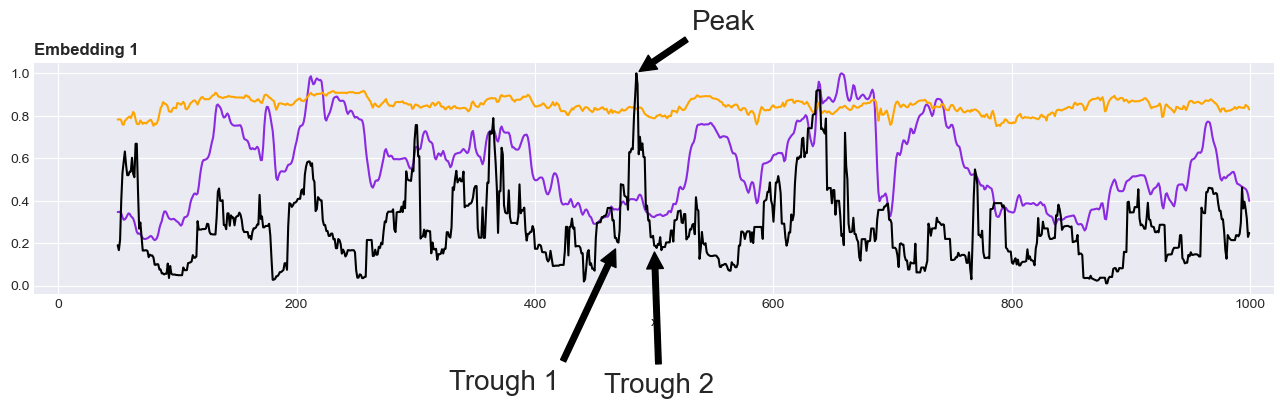

In [16]:
avgl1normsnonoise = []
avgl2normsnonoise = []


from spectrum import Periodogram
p = Periodogram(y1
#                 , sampling=len(simulated_data1)
               )
p.run()


for lag in range(1,2):
    simulated_data = pd.DataFrame({'Simulated Data 1' : y1
                 })
    simulated_data['Simulated Data 2'] = simulated_data['Simulated Data 1'].shift(lag)
    simulated_data = simulated_data.dropna()

    # Create point cloud
    window_size = 50
    stride = 1
    df = simulated_data
    X = df
    y = df.index
    SW = SlidingWindow(size=window_size, stride=stride)
    X_sw, yr = SW.fit_transform_resample(X, y)

    # Calculate the norms for each of the windows in the multivariate sliding window
    variabilitys = np.empty(window_size -1 + lag)
    variabilitys[:] = np.nan
    variabilitys = list(variabilitys)

    correlations = np.empty(window_size -1 + lag)
    correlations[:] = np.nan
    correlations = list(correlations)
    
    Norms = np.empty(window_size-1 + lag)
    Norms[:] = np.nan
    Norms = list(Norms)
    
    l2Norms = np.empty(window_size-1 + lag)
    l2Norms[:] = np.nan
    l2Norms = list(l2Norms)
    
    layers = 10
    vrp = VietorisRipsPersistence()
    pl = PersistenceLandscape(layers)
    for pointcloud in X_sw:
        persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
        landscapedata = pl.fit_transform(persistencediagram)
        tseq = Ftseq(persistencediagram[0])
        Norms.append(Lpnorm(tseq, landscapedata[0], p = 1))    
        l2Norms.append(Lpnorm(tseq, landscapedata[0], p = 2))
    
        pointcloudcovmatrix = np.array(pd.DataFrame(pointcloud).cov())
        variabilitys.append((pointcloudcovmatrix[0][0]  + pointcloudcovmatrix[1][1]) / 2)
    
        pointcloudcorrmatrix = np.array(pd.DataFrame(pointcloud).corr())
        correlations.append(np.round(pointcloudcorrmatrix[0][1], 5))
    

    

    simulateddata1normalized = simulated_data['Simulated Data 1']/simulated_data['Simulated Data 1'].max()
    simulateddata2normalized = simulated_data['Simulated Data 2']/simulated_data['Simulated Data 2'].max()
    avgl1normsnonoise.append(pd.Series(Norms).mean())
    avgl2normsnonoise.append(pd.Series(l2Norms).mean())
    Norms = np.array(Norms) / pd.Series(Norms).max() if pd.Series(Norms).max() != 0 else np.array(Norms)*0
    l2Norms = np.array(l2Norms) / pd.Series(l2Norms).max() if pd.Series(l2Norms).max() != 0 else np.array(l2Norms)*0
    variabilitys = np.array(variabilitys) / pd.Series(variabilitys).max() if pd.Series(variabilitys).max() != 0 else np.array(variabilitys)*0


plt.figure(figsize = (16,3))
plt.style.use('seaborn-darkgrid')
plt.subplots_adjust(hspace=.5)
plt.plot(variabilitys, color = 'blueviolet', label = 'Variability (Normalized)')
#     corrlabel = 'Correlation' if maxcorr >= 0 else 'Correlation (Negative)'
corrlabel = 'Correlation'
plt.plot(correlations, color = 'orange', label = corrlabel)
plt.plot(Norms, color = 'black', label = 'L1 Norm (Normalized)')
plt.title('Embedding 1' , fontweight = 'bold', loc='left')
plt.xlabel('x')
plt.xlim([-20,1020])
plt.annotate('Peak', 
            xy=(485, Norms[485]),
            xycoords= 'data',
            xytext=(485+ 100, Norms[485] + .3), 
#             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)

plt.annotate('Trough 1', 
            xy=(470, Norms[470]),
            xycoords= 'data',
            xytext=(470 - 50, Norms[470] -.6), 
#             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)


plt.annotate('Trough 2', 
            xy=(500, Norms[500]),
            xycoords= 'data',
            xytext=(500 + 50, Norms[500] -.6), 
#             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)
plt.show() 

Peak


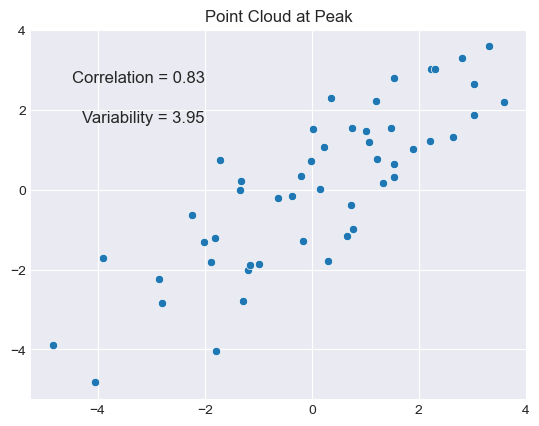

In [17]:
print('Peak')
index = 485 - 50
pointcloud = X_sw[index]

sns.scatterplot(pointcloud[:,0], pointcloud[:,1])
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-2, 3),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-2, 2),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.title('Point Cloud at Peak')
plt.show()

from gtda.homology import VietorisRipsPersistence
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)
vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape), plotly_params = dict(row=1, col=2))



layers = 3
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params = dict(row=2, col=2))





Trough 1


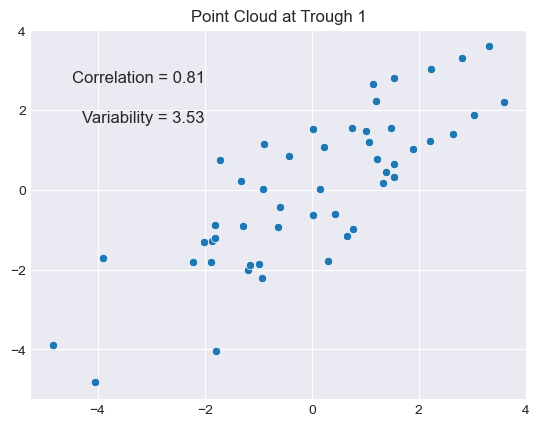

In [18]:
print('Trough 1')
index = 485 - 50 - 15
pointcloud = X_sw[index]
sns.scatterplot(pointcloud[:,0], pointcloud[:,1])

plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-2, 3),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-2, 2),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.title('Point Cloud at Trough 1')
plt.show()
from gtda.homology import VietorisRipsPersistence


vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

layers = 3
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params=None)

Trough 2


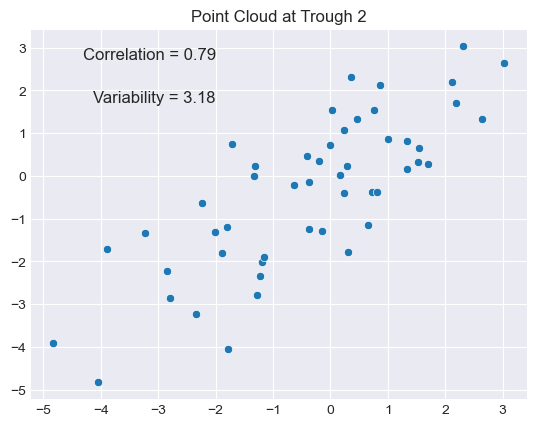

In [19]:
print('Trough 2')

index = 485 - 50 + 15
pointcloud = X_sw[index]
sns.scatterplot(pointcloud[:,0], pointcloud[:,1])
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-2, 3),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-2, 2),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.title('Point Cloud at Trough 2')
plt.show()


vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

layers = 3
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params=None)

## Anomaly 2

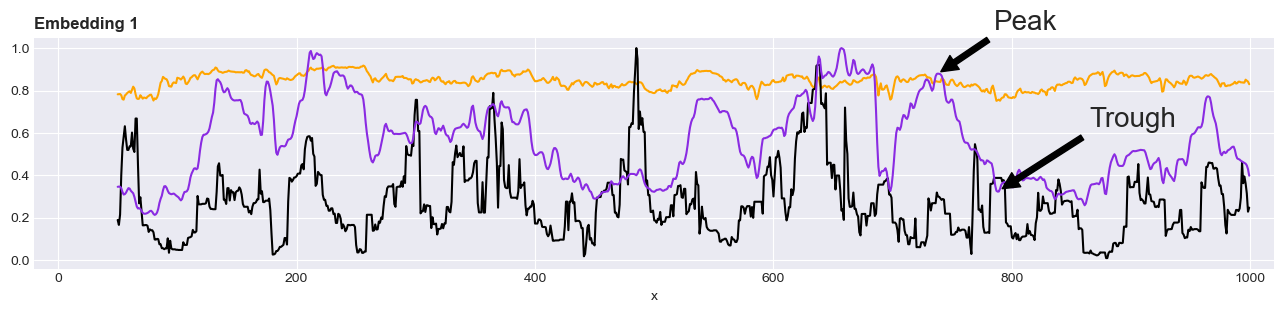

In [20]:
plt.figure(figsize = (16,3))
plt.style.use('seaborn-darkgrid')
plt.subplots_adjust(hspace=.5)
corrlabel = 'Correlation'
plt.plot(correlations, color = 'orange', label = corrlabel)
plt.plot(Norms, color = 'black', label = 'L1 Norm (Normalized)')
plt.plot(variabilitys, color = 'blueviolet', label = 'Variability (Normalized)')
#     corrlabel = 'Correlation' if maxcorr >= 0 else 'Correlation (Negative)'


plt.title('Embedding 1' , fontweight = 'bold', loc='left')
plt.xlabel('x')
plt.xlim([-20,1020])
plt.annotate('Peak', 
            xy=(738, variabilitys[738]),
            xycoords= 'data',
            xytext=(738+ 100, variabilitys[738] + .3), 
#             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)

plt.annotate('Trough', 
            xy=(788, variabilitys[788]),
            xycoords= 'data',
            xytext=(788 + 150, variabilitys[788] +.4), 
#             textcoords=’axes fraction’,
            arrowprops=dict(facecolor= 'black', shrink=0.05),
            horizontalalignment='right',
            verticalalignment= 'top',
            size = 20)

plt.show() 

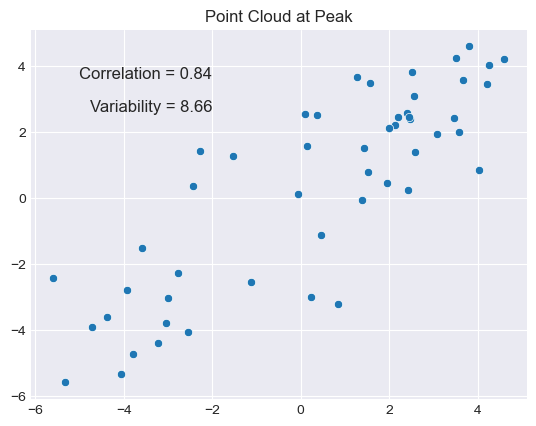

In [21]:
index = 738 - 50
pointcloud = X_sw[index]

sns.scatterplot(pointcloud[:,0], pointcloud[:,1])
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-2, 4),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-2, 3),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.title('Point Cloud at Peak')
plt.show()

from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)
vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape), plotly_params = dict(row=1, col=2))



layers = 3
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params = dict(row=2, col=2))

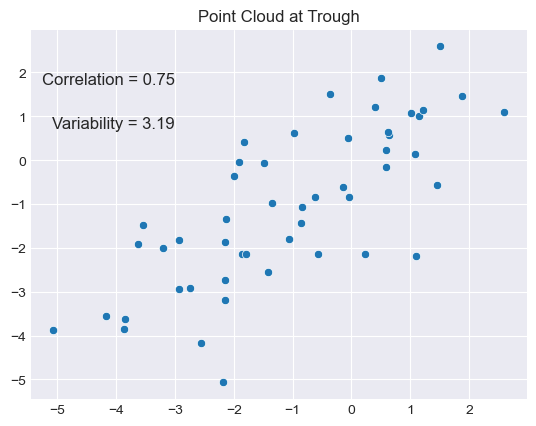

In [22]:

index = 788 - 50
pointcloud = X_sw[index]

sns.scatterplot(pointcloud[:,0], pointcloud[:,1])
plt.annotate('Correlation = ' + str(round(np.corrcoef(X_sw[index][:,0], X_sw[index][:,1])[0,1], 2)), 
        xy=(-3, 2),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.annotate('Variability = ' + str(round((np.var(X_sw[index][:,0]) + np.var(X_sw[index][:,1])) / 2, 2)), 
        xy=(-3, 1),
        xycoords= 'data',
        arrowprops=dict(facecolor= 'black'
                        , shrink=0.1
                       ),
        horizontalalignment='right',
        verticalalignment= 'top',
        size = 12)
plt.title('Point Cloud at Trough')
plt.show()

from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)
vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape), plotly_params = dict(row=1, col=2))



layers = 3
pl = PersistenceLandscape(layers)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, 
        homology_dimensions = [1], 
        plotly_params = dict(row=2, col=2))